In [2]:
import os
import json
import time
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

# Functions : preprocess() (create dataloaders from raw data) 
# load_models() (load tokenizers and models) training() (loop of one training step) evaluate()

In [3]:
# dummy dataset with two labels for now
articles = ['J\'adore vraiment les fake news', 'Beaucoup beaucoup', 'c\'est génial', 'Encore une fake news que voici']
  
labels = [0, 1, 1, 0]

dataset = pd.DataFrame(list(zip(articles, labels)),
               columns =['article', 'label'])

dataset.head()

,article,label
0,J'adore vraiment les fake news,0
1,Beaucoup beaucoup,1
2,c'est génial,1
3,Encore une fake news que voici,0


In [4]:
PATH = 'text_dataset_1000.csv'
fields = ['label', 'article']
df = pd.read_csv(PATH, usecols=fields)

In [5]:
df.dropna(subset=['article'], inplace=True)

In [6]:
df['label'] = df['label'].replace([1], 0) # true label is now 0
df['label'] = df['label'].replace([2, 3], 1) # fake and biased label are now 1

In [7]:
dataset = df

articles = dataset['article'].values.tolist()
labels = dataset['label'].values.tolist()

TOKENIZER = CamembertTokenizer.from_pretrained(
    'camembert-base',
    do_lower_case=True)

In [8]:
def preprocess(raw_articles, labels=None):
    """
        Create pytorch dataloader from raw data
    """

    

    encoded_batch = TOKENIZER.batch_encode_plus(raw_articles,
                                                add_special_tokens=False,
                                                truncation = True,
                                                pad_to_max_length=True,
                                                return_attention_mask=True,
                                                return_tensors = 'pt')

    encoded_input_trc={} # truncation
    for k,v in encoded_batch.items():
        v_truncated = v[:,:512]
        encoded_input_trc[k]=v_truncated

    if labels:
        labels = torch.tensor(labels)
        return encoded_input_trc['input_ids'], encoded_input_trc['attention_mask'], labels
    return encoded_batch['input_ids'], encoded_batch['attention_mask']
print(preprocess(articles, labels=labels)[0].size())

torch.Size([764, 512])


In [9]:
# Split train-validation
split_border = int(len(labels)*0.8)
articles_train, articles_validation = articles[:split_border], articles[split_border:]
labels_train, labels_validation = labels[:split_border], labels[split_border:]

In [10]:
input_ids, attention_mask, labels_train = preprocess(articles_train, labels_train)
# Combine the training inputs into a TensorDataset
train_dataset = TensorDataset(
    input_ids,
    attention_mask,
    labels_train)
    

input_ids, attention_mask, labels_validation = preprocess(articles_validation, labels_validation)
# Combine the validation inputs into a TensorDataset
validation_dataset = TensorDataset(
    input_ids,
    attention_mask,
    labels_validation)


In [11]:
batch_size = 32

# Create the DataLoaders
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size)

In [14]:
model = CamembertForSequenceClassification.from_pretrained(
        'camembert-base',
        num_labels = 2)

model.resize_token_embeddings(512)

Embedding(512, 768)

In [15]:
def predict(articles, model=model):
    with torch.no_grad():
        model.eval()
        input_ids, attention_mask = preprocess(articles)
        output = model(input_ids, attention_mask=attention_mask)
        return torch.argmax(output[0], dim=1)
predict(articles_train)

# Problem with the size of the embedding layer ??

IndexError: index out of range in self

In [1]:
def evaluate(articles, labels, metric='report'):
    predictions = predict(articles)
    if metric == 'report':
        return metrics.classification_report(labels, predictions, zero_division=0)
    elif metric == 'matrix':
        return metrics.confusion_matrix(labels, predictions)

In [33]:
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [34]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # Learning Rate - Default is 5e-5
                  eps = 1e-8 # Adam Epsilon  - Default is 1e-8.
                )

In [50]:
SAVE_PATH = "" #ADD PATH

# Training loop
training_stats = []
                                                                                
# Measure the total training time for the whole run.
total_t0 = time.time()

epochs = 20

# Total number of training steps is [number of batches] x [number of epochs]
# (Note that this is not the same as the number of training samples)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

device = torch.device("cpu")

# This variable will evaluate the convergence on the training
consecutive_epochs_with_no_improve = 0

# Training
for epoch in range(0, epochs):
    
    print("")
    print(f'########## Epoch {epoch} / {epochs} ##########')
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = time.time() - t0
            
            # Report progress
            print(f'  Batch {step}  of  {len(train_dataloader)}    Elapsed: {format_time(elapsed)}.')

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
        #
        # 'batch' contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: skills 
        input_id = batch[0].to(device)
        attention_mask = batch[1].to(device)
        sentiment = batch[2].to(device)

        # Clear any previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch)
        # the loss (because we provided skills) and the "logits"--the model
        # outputs prior to activation
        loss, logits = model(input_id, 
                             token_type_ids=None, 
                             attention_mask=attention_mask, 
                             labels=sentiment)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. 'loss' is a Tensor containing a
        # single value; the '.item()' function just returns the Python value 
        # from the tensor
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)   

    if epoch > 0:
        if min([stat['Training Loss'] for stat in training_stats]) <= avg_train_loss:
            # i.e. If there is not improvement
            consecutive_epochs_with_no_improve += 1
        else:
            # If there is improvement
            """consecutive_epochs_with_no_improve = 0
            print("Model saved!")
            torch.save(model.state_dict(), SAVE_PATH)"""
    
    # Measure how long this epoch took
    training_time = time.time() - t0

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )
    if consecutive_epochs_with_no_improve == 2:
        print("Stop training : The loss has not changed since 2 epochs!")
        break
        


########## Epoch 0 / 20 ##########
Training...

  Average training loss: 0.58
  Training epoch took: 0.8234171867370605
[{'epoch': 1, 'Training Loss': 0.5791782140731812, 'Training Time': 0.8234171867370605}]

########## Epoch 1 / 20 ##########
Training...

  Average training loss: 0.61
  Training epoch took: 0.7711901664733887
[{'epoch': 1, 'Training Loss': 0.5791782140731812, 'Training Time': 0.8234171867370605}, {'epoch': 2, 'Training Loss': 0.6053993105888367, 'Training Time': 0.7711901664733887}]

########## Epoch 2 / 20 ##########
Training...

  Average training loss: 0.56
  Training epoch took: 0.7623836994171143
[{'epoch': 1, 'Training Loss': 0.5791782140731812, 'Training Time': 0.8234171867370605}, {'epoch': 2, 'Training Loss': 0.6053993105888367, 'Training Time': 0.7711901664733887}, {'epoch': 3, 'Training Loss': 0.559131920337677, 'Training Time': 0.7623836994171143}]

########## Epoch 3 / 20 ##########
Training...

  Average training loss: 0.57
  Training epoch took: 0.755

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



<AxesSubplot:>

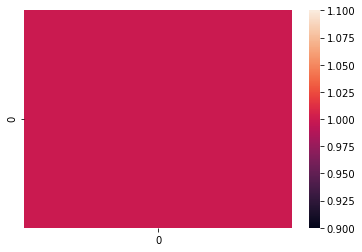

In [37]:
# Evaluation with the confusion matrix
import seaborn
confusion_matrix = evaluate(articles_validation, labels_validation, 'matrix')
report = evaluate(articles_validation, labels_validation, 'report')
print(report)
seaborn.heatmap(confusion_matrix)
# precision    recall  f1-score   support

#            0       0.96      0.96      0.96       482
#            1       0.98      0.99      0.99      1322

#     accuracy                           0.98      1804
#    macro avg       0.97      0.97      0.97      1804
# weighted avg       0.98      0.98      0.98      1804

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



<AxesSubplot:>

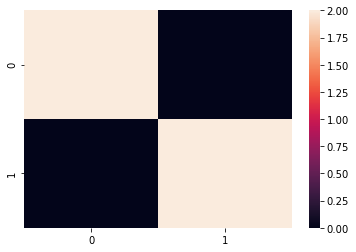

In [42]:
import seaborn
confusion_matrix = evaluate(articles, labels, 'matrix')
report = evaluate(articles, labels, 'report')
print(report)
seaborn.heatmap(confusion_matrix)

In [48]:
predict(['Le réchauffement climatique est un complot des illuminatis'])

tensor([0])